# Training: Curriculum

#### 1) Train on various close-to-terminal standard situations
#### 2) Train on self-play episodes of the champion
#### 3) Avoid frustrating the freshling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
from aegomoku.game_data import read_training_data
from aegomoku.trainer import Trainer
from aegomoku.game_data import create_dataset
from aegomoku.utils import analyse_example

2022-08-31 16:54:24.323329: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-31 16:54:25.364174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 16:54:25.395119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-31 16:54:25.395130: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tenso

In [3]:
BOARD_SIZE = 15

---

# Read curriculum game data

In [4]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

trajectories/mcts/the_heuristic_200.pickle
41256 3 (17, 17, 3)
trajectories/policy/terminal_opportunities.pickle
1424 3 (17, 17, 3)
trajectories/policy/terminal_threats.pickle
20320 3 (17, 17, 3)


## A quick peek into the course material

trajectories/mcts/the_heuristic_200.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.8543996576211147
trajectories/policy/terminal_opportunities.pickle
Next to play: BLACK
Value from BLACK's point of view: 0.9482803571583632
trajectories/policy/terminal_threats.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.6130136416610247


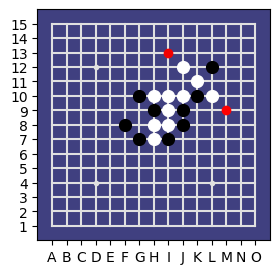

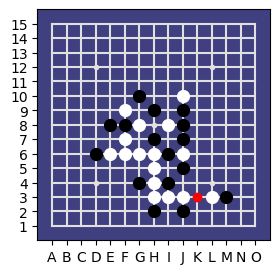

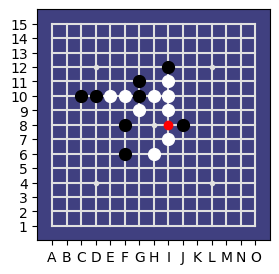

In [5]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [6]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=1024, num_blocks=20)
model.compile()
model.summary()

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yod7Mf1y/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[

---


# Execute the curriculum
The idea here is to first teach the aspects of recognizing near-terminals in both directions: opportunities and threats.

Then mixing any other game position into the trainings to see the network improve on all subjects.

In [7]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [8]:
# Step one: understand almost-terminal positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup[1:]:
        trainer.train(ds, epochs_per_train=10, report_every=None)

Day 1:
Epoch: 10, Training: (4.985687, 0.13718018)
Epoch: 10, Training: (4.980695, 1.69714)
Day 2:
Epoch: 10, Training: (5.1134324, 0.9200196)
Epoch: 10, Training: (5.154683, 0.40040317)
Day 3:
Epoch: 10, Training: (5.1074667, 0.8019865)
Epoch: 10, Training: (5.114665, 0.4145247)
Day 4:
Epoch: 10, Training: (5.055144, 0.7789184)
Epoch: 10, Training: (4.9667726, 0.4313193)
Day 5:
Epoch: 10, Training: (4.876377, 0.49593744)
Epoch: 10, Training: (4.7355304, 0.693576)
Day 6:
Epoch: 10, Training: (5.0163774, 0.7913463)
Epoch: 10, Training: (5.0207434, 0.42244807)
Day 7:
Epoch: 10, Training: (4.8430467, 0.7692127)
Epoch: 10, Training: (4.2794237, 0.43858042)
Day 8:
Epoch: 10, Training: (3.3779998, 0.74727255)
Epoch: 10, Training: (2.913631, 0.4553586)
Day 9:
Epoch: 10, Training: (2.7108576, 0.7443697)
Epoch: 10, Training: (2.291566, 0.44275707)
Day 10:
Epoch: 10, Training: (2.4416213, 0.73348075)
Epoch: 10, Training: (1.8281631, 0.44960293)


In [9]:
# Step 2: mix in all other positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup:
        trainer.train(ds, epochs_per_train=20, report_every=20)

Day 1:
Epoch: 20, Training: (2.8022432, 0.38183326)
Epoch: 20, Training: (2.2740073, 0.7176774)
Epoch: 20, Training: (2.0638003, 0.47753572)
Day 2:
Epoch: 20, Training: (2.7316377, 0.3813209)
Epoch: 20, Training: (2.3041656, 0.6982595)
Epoch: 20, Training: (1.7016268, 0.4894845)
Day 3:
Epoch: 20, Training: (2.700731, 0.38097057)
Epoch: 20, Training: (2.035065, 0.681825)
Epoch: 20, Training: (1.7679402, 0.5001512)
Day 4:
Epoch: 20, Training: (2.6855567, 0.38070467)
Epoch: 20, Training: (1.9486015, 0.6672549)
Epoch: 20, Training: (1.6895063, 0.50954914)
Day 5:
Epoch: 20, Training: (2.6292496, 0.38052303)
Epoch: 20, Training: (1.7752987, 0.6545242)
Epoch: 20, Training: (1.6366427, 0.51797736)
Day 6:
Epoch: 20, Training: (2.6225743, 0.38034528)
Epoch: 20, Training: (1.9090351, 0.64330757)
Epoch: 20, Training: (1.4963958, 0.52528113)
Day 7:
Epoch: 20, Training: (2.5989935, 0.38015467)
Epoch: 20, Training: (1.6224592, 0.6339963)
Epoch: 20, Training: (1.497615, 0.5314199)
Day 8:
Epoch: 20, Tr

---

In [10]:
## The full training

In [11]:
for i in range(5):
    print(f"Day {i+1}:")
    for ds in datasets_main:
        trainer.train(ds, epochs_per_train=20, report_every=None)

Day 1:
Epoch: 20, Training: (2.144484, 0.24313006)
Epoch: 20, Training: (1.1960089, 0.27112392)
Epoch: 20, Training: (1.2655241, 0.23574409)
Day 2:


KeyboardInterrupt: 

exit


---

# Performance on formerly unseen data

n=36011
Next to play: BLACK
Value from BLACK's point of view: 0.799886155502954
Next to play: BLACK
Value from BLACK's point of view: -0.408933162689209


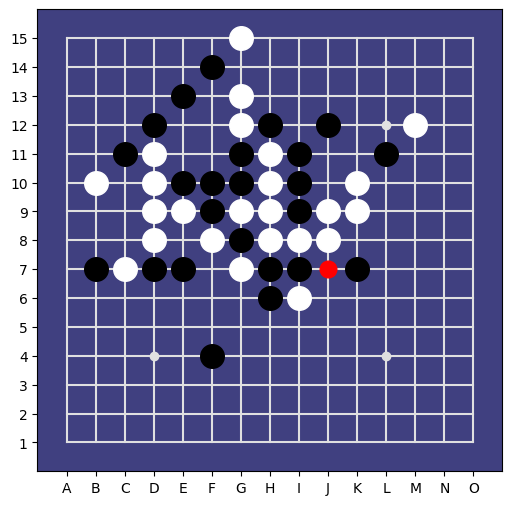

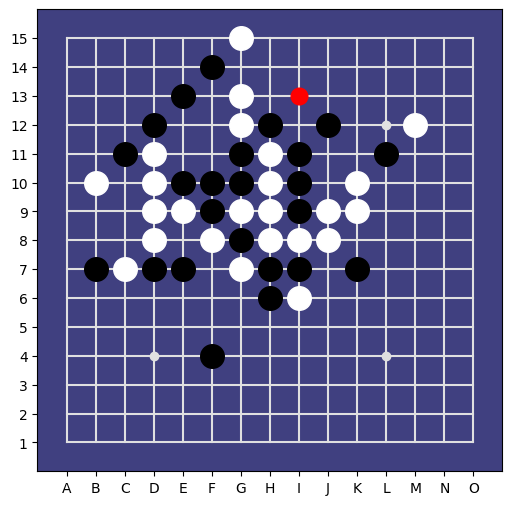

In [30]:
from aegomoku.utils import analyse_example
training_data = curriculum[0]

n = random.randint(N_main[0], len(training_data))
sample = np.expand_dims(training_data[n][0], axis=0).astype(float)

# Training Material
print(f"n={n}")
analyse_example(BOARD_SIZE, training_data[n])

# Learned
s, p, v = training_data[n]
p_learned, v_learned = model(sample)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)